<a href="https://colab.research.google.com/github/emanbuc/ultrasonic-vision/blob/main/notebooks/create_training_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisi dati di training per le varie classi di oggetti

# Explore Dataset
Load full dataset into a Pandas dataframe. A small dataset (500 rows) can be fully loaded in memory.

Time column is not relevant for classification and in not included in dataframe

In [1]:
# Univariate Histograms
import matplotlib.pyplot as plt
import pandas
url = "https://raw.githubusercontent.com/emanbuc/ultrasonic-vision/main/dataset/20210102_alldata_outlier_removed.csv"

names = ['HCSR04_001', 'HCSR04_002', 'HCSR04_003', 'HCSR04_004', 'HCSR04_005', 'HCSR04_006', 'HCSR04_007','ObjectClass']
data = pandas.read_csv(url, usecols=names)
print(data)

     HCSR04_001  HCSR04_002  HCSR04_003  ...  HCSR04_006  HCSR04_007  ObjectClass
0         55.59       16.09       54.78  ...       57.48       96.38  BALL_CENTER
1         56.40       16.06       55.29  ...       57.42      109.68  BALL_CENTER
2         56.32       16.04       54.86  ...       58.30      116.21  BALL_CENTER
3         55.08       15.96       54.87  ...       58.28       78.56  BALL_CENTER
4         55.11       15.96       55.22  ...       57.86      111.51  BALL_CENTER
..          ...         ...         ...  ...         ...         ...          ...
302       53.43       55.59       55.07  ...       51.77      109.41    WALL_BALL
303       53.40       55.57       55.13  ...       52.60      107.89    WALL_BALL
304       53.83       55.60       55.14  ...       51.70      111.39    WALL_BALL
305       53.40       55.97       55.08  ...       51.74      109.09    WALL_BALL
306       53.41       55.63       54.76  ...       52.51      108.74    WALL_BALL

[307 rows x 8 c

## Univariate Plots

### Histogram

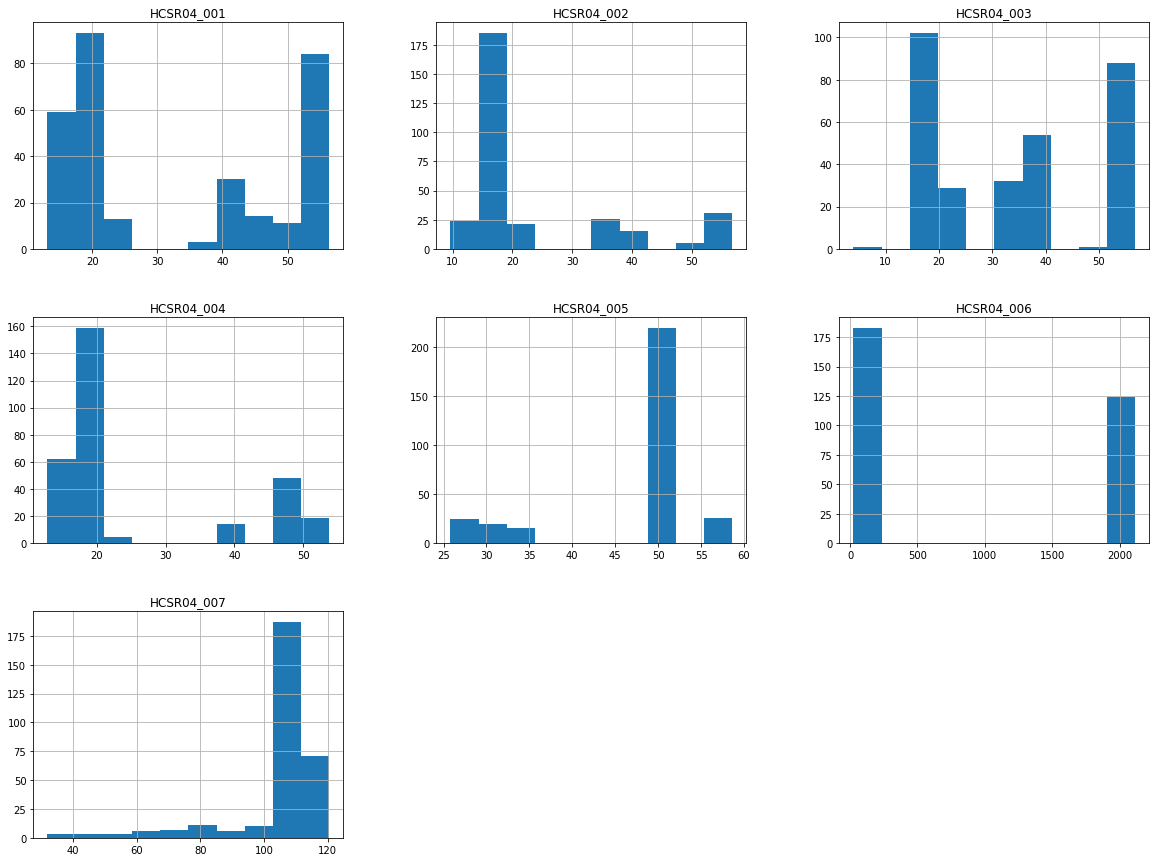

In [2]:
data.iloc[:,[0,1,2,3,4,5,6,7]].hist(figsize=(20,15))
plt.show()

### Density Plots


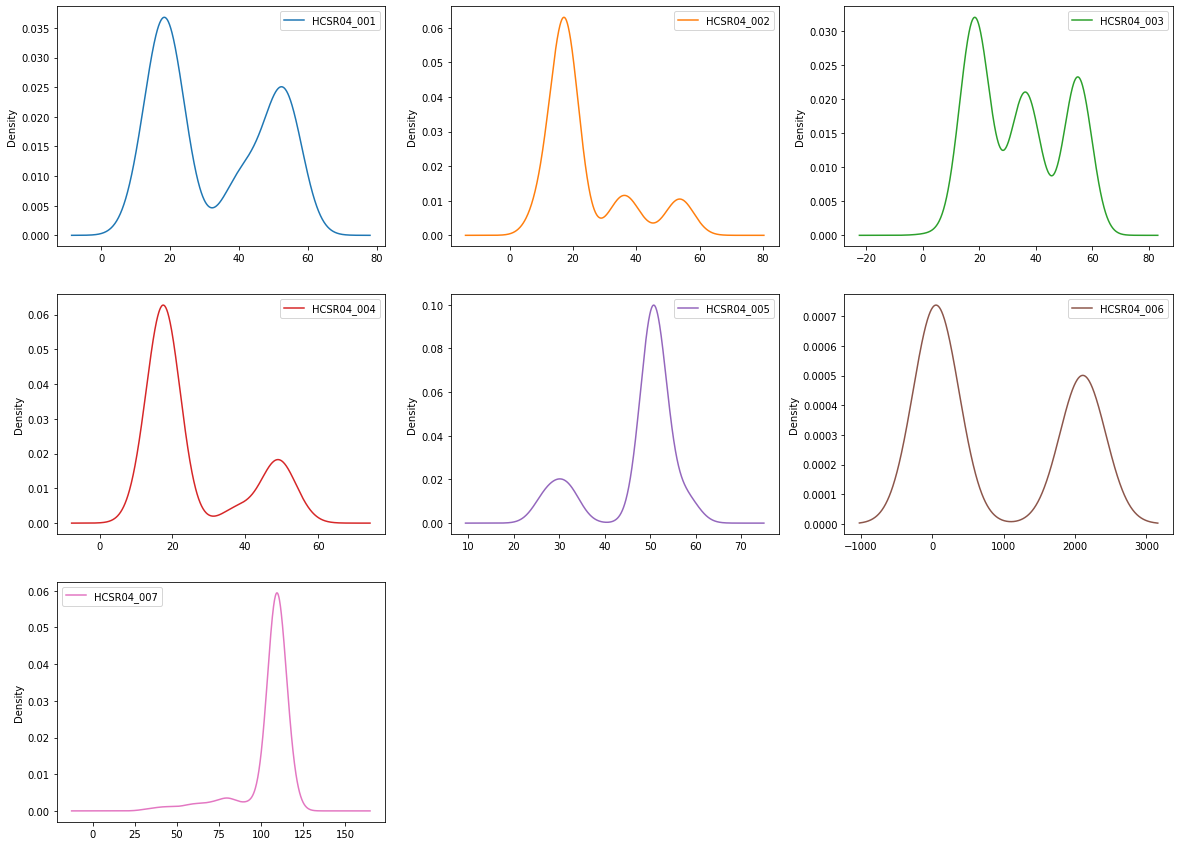

In [3]:
data.plot(kind='density', subplots=True, layout=(3,3), sharex=False, figsize=(20,15))
plt.show()

### Box and Whisker Plots (Boxplot)
Boxplots summarize the distribution of each attribute, drawing a line for the median (middle value) and a box around the 25th and 75th percentiles (the middle 50% of the data). The whiskers give an idea of the spread of the data and dots outside of the whiskers show candidate outlier values (values that are 1.5 times greater than the size of spread of the middle 50% of the data).

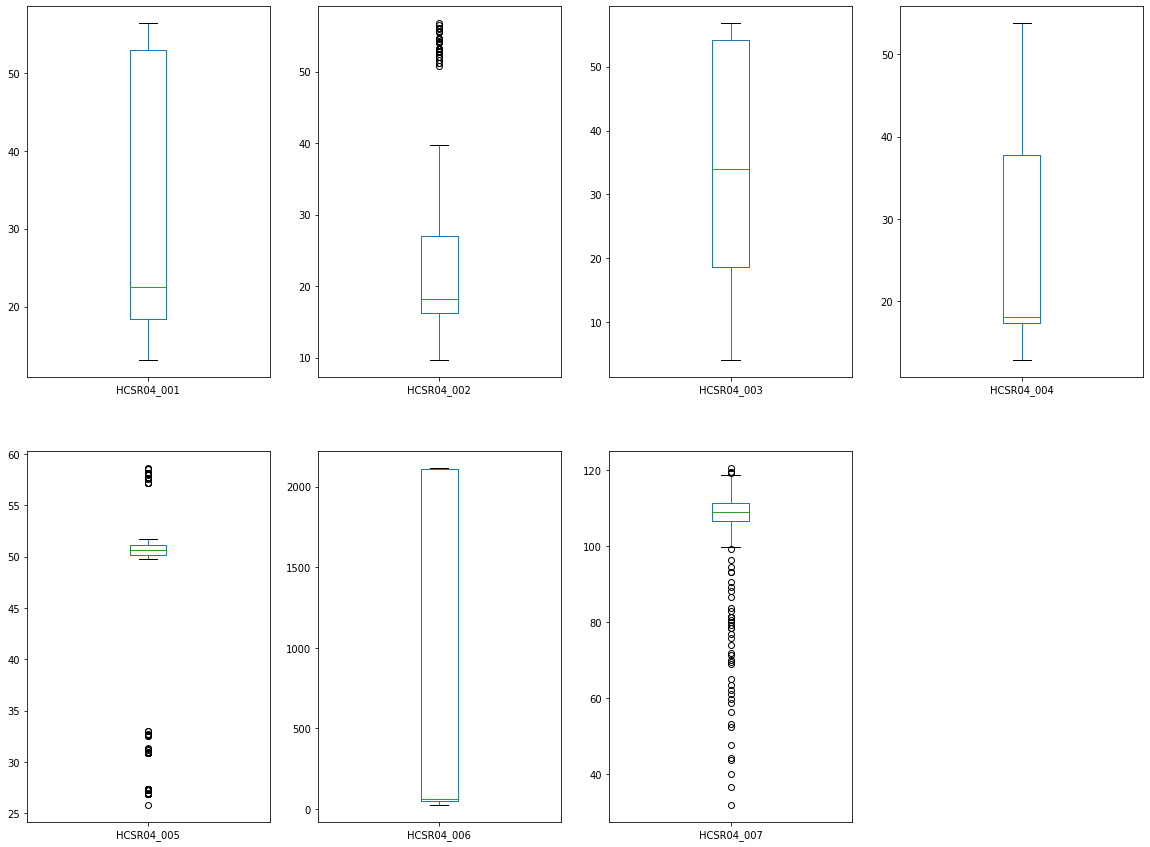

In [4]:
data.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False,figsize=(20,15))
plt.show()

### Osservazioni
Nella configurazione "seven sensors" l'area di misura era delimitata da pannelli in cartone posizionati parallelemente al piano frontale dei sensori a distanze comprese tra i 50 e 60 cm.  L'analisi dei dati acquisiti mostra la presenza di numerose misure anomale




#### Analisi anomalie HCSR04_007

Analisi dei dati prodotti da HCSR04_007 senza nessun oggetto presente

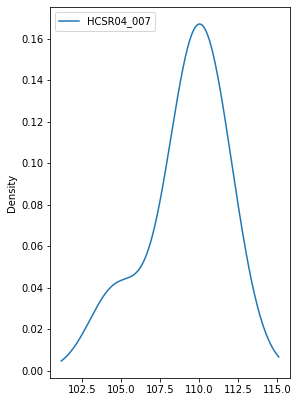

,HCSR04_007,ObjectClass
70,104.63,EMPTY_SEVEN
71,109.74,EMPTY_SEVEN
72,109.62,EMPTY_SEVEN
73,108.72,EMPTY_SEVEN
74,111.61,EMPTY_SEVEN
75,110.71,EMPTY_SEVEN


In [5]:
names = ['HCSR04_007','ObjectClass']
data_HCSR04_007 = pandas.read_csv(url, usecols=names)
HCSR04_007_grouped= data_HCSR04_007.groupby(['ObjectClass'])
HCSR04_007_EMPTY_SEVEN= HCSR04_007_grouped.get_group('EMPTY_SEVEN')

HCSR04_007_EMPTY_SEVEN.plot(kind='density', subplots=True, layout=(2,6), sharex=False, figsize=(30,15))
plt.show()
HCSR04_007_EMPTY_SEVEN

C'è un sistematico su HCSR04_007 che sposta il picco intorno a 100 cm piuttosto che inntorno a 50 cm. 

#### Analisi anomalie HCSR04_006

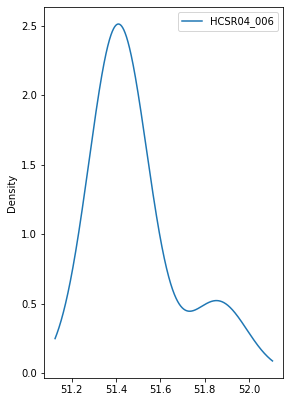

,HCSR04_006,ObjectClass
70,51.44,EMPTY_SEVEN
71,51.37,EMPTY_SEVEN
72,51.42,EMPTY_SEVEN
73,51.86,EMPTY_SEVEN
74,51.39,EMPTY_SEVEN
75,51.43,EMPTY_SEVEN


In [6]:
names = ['HCSR04_006','ObjectClass']
data_HCSR04_006 = pandas.read_csv(url, usecols=names)
HCSR04_006_grouped= data_HCSR04_006.groupby(['ObjectClass'])
HCSR04_006_EMPTY_SEVEN= HCSR04_006_grouped.get_group('EMPTY_SEVEN')

HCSR04_006_EMPTY_SEVEN.plot(kind='density', subplots=True, layout=(2,6), sharex=False, figsize=(30,15))
plt.show()
HCSR04_006_EMPTY_SEVEN

il sensore sembra funzionare correttamente. Le misure anomale (outliar) sono probabilmente da attribuire a fenomeni di multipath e scattering

## New Features

Le distanze dipendono fortemente dalla posizione esatta dell'oggetto all'interno dell'area di misura. I modelli addestrati presentano problemi di overfitting. Aggiungo nuove feature derivate per cercare di ottenere una classificazione più robusta.

In [7]:
df_EMPTY=data[data['ObjectClass']=='EMPTY_SEVEN']
distanceColumns= ['HCSR04_001', 'HCSR04_002', 'HCSR04_003', 'HCSR04_004', 'HCSR04_005', 'HCSR04_006', 'HCSR04_007']
categorialColumns =['ObjectClass']

### Oggetto Rilevato

In [8]:
for colName in distanceColumns:
  maxValue= max(df_EMPTY[colName])
  minValue= min(df_EMPTY[colName])
  print(colName+ "min: "+str(minValue)+"max: "+str(maxValue))
  data[colName+'_empty']= (data[colName]<= maxValue) & (data[colName] >=minValue)
  categorialColumns.append(colName+'_empty')

data

HCSR04_001min: 53.18max: 53.33
HCSR04_002min: 54.14max: 54.67
HCSR04_003min: 55.94max: 56.81
HCSR04_004min: 53.7max: 53.77
HCSR04_005min: 50.43max: 50.55
HCSR04_006min: 51.37max: 51.86
HCSR04_007min: 104.63max: 111.61


,HCSR04_001,HCSR04_002,HCSR04_003,HCSR04_004,HCSR04_005,HCSR04_006,HCSR04_007,ObjectClass,HCSR04_001_empty,HCSR04_002_empty,HCSR04_003_empty,HCSR04_004_empty,HCSR04_005_empty,HCSR04_006_empty,HCSR04_007_empty
0,55.59,16.09,54.78,17.55,51.73,57.48,96.38,BALL_CENTER,False,False,False,False,False,False,False
1,56.40,16.06,55.29,17.48,51.27,57.42,109.68,BALL_CENTER,False,False,False,False,False,False,True
2,56.32,16.04,54.86,17.55,51.26,58.30,116.21,BALL_CENTER,False,False,False,False,False,False,False
3,55.08,15.96,54.87,17.62,51.24,58.28,78.56,BALL_CENTER,False,False,False,False,False,False,False
4,55.11,15.96,55.22,17.57,51.71,57.86,111.51,BALL_CENTER,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,53.43,55.59,55.07,52.16,51.25,51.77,109.41,WALL_BALL,False,False,False,False,False,True,True
303,53.40,55.57,55.13,52.10,51.71,52.60,107.89,WALL_BALL,False,False,False,False,False,False,True
304,53.83,55.60,55.14,52.53,51.29,51.70,111.39,WALL_BALL,False,False,False,False,False,True,True
305,53.40,55.97,55.08,52.22,51.17,51.74,109.09,WALL_BALL,False,False,False,False,False,True,True


## Binning

In [9]:
import numpy as np

binLabels=["NEAR","CENTER","FAR"]
binCuts=[-np.inf,20,40,np.inf]

for colName in distanceColumns:
  bins= pandas.cut(data[colName], bins=binCuts,labels=binLabels)
  data[colName+'_BIN']=bins
  categorialColumns.append(colName+'_BIN')

data[data['HCSR04_001'] < 20]
categorialColumns

['ObjectClass',
 'HCSR04_001_empty',
 'HCSR04_002_empty',
 'HCSR04_003_empty',
 'HCSR04_004_empty',
 'HCSR04_005_empty',
 'HCSR04_006_empty',
 'HCSR04_007_empty',
 'HCSR04_001_BIN',
 'HCSR04_002_BIN',
 'HCSR04_003_BIN',
 'HCSR04_004_BIN',
 'HCSR04_005_BIN',
 'HCSR04_006_BIN',
 'HCSR04_007_BIN']

## Multivariare plot

In [11]:
# The data is categorial so I convert it with LabelEncoder to transfer to ordinal.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()
for column in categorialColumns:
    data[column] = labelencoder.fit_transform(data[column])

In [20]:
dataCategoricalOnly = data.loc[:,categorialColumns]

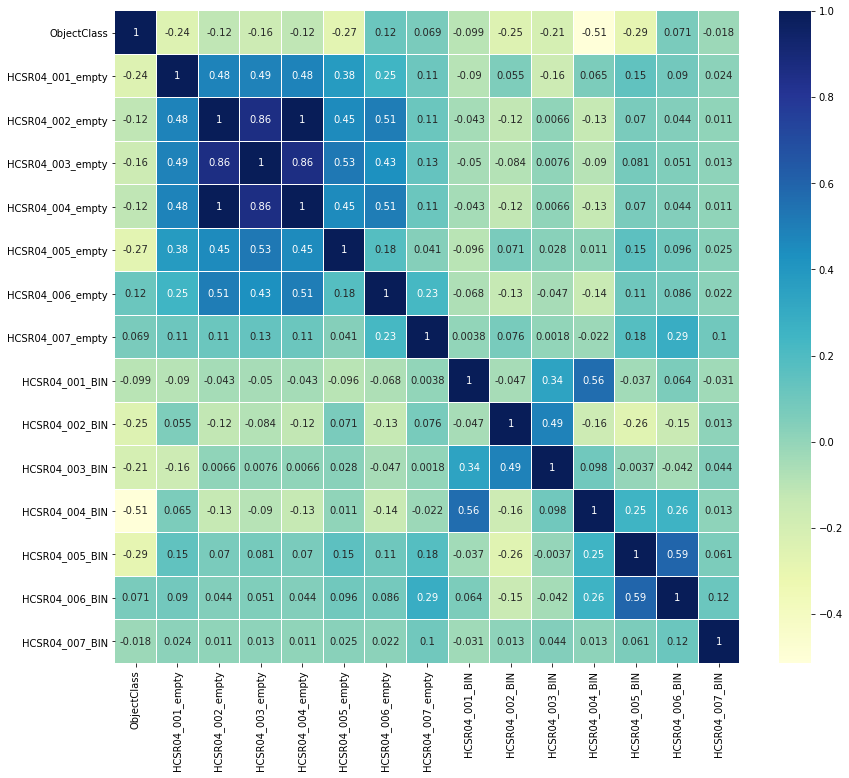

In [21]:
import seaborn as sns
plt.figure(figsize=(14,12))
sns.heatmap(dataCategoricalOnly.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);